In [1]:
#abtem version: 74a1b7d3cd1d634c86dede5a220247e8034d11a4
import os
#os.environ["MKL_NUM_THREADS"] = "16"
#os.environ["NUMEXPR_NUM_THREADS"] = "16"
#os.environ["OMP_NUM_THREADS"] = "16"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from abtem import *
from ase.io import read
from ase.build import surface

from abtem.structures import orthogonalize_cell
from abtem.measure import center_of_mass

In [3]:
from abtem.detect import AnnularDetector
from abtem.noise import poisson_noise
import scipy.constants as c
from scipy.optimize import minimize
from collections import defaultdict
from abtem.scan import PositionScan
from abtem.reconstruct import invms

from abtem.measure import bandlimit

from abtem.custom import get_gaussian_spread
from abtem.custom import get_radiation_dose
from abtem.custom import incoherent_scan
from abtem.custom import incoherent_scan_mc
from abtem.custom import sample_probe
from abtem.custom import incoherent_scan_mc_fp
from abtem.custom import incoherent_probe, get_probe_radius

In [4]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20, 20)
matplotlib.rcParams['lines.linewidth'] = 2
font = {'weight' : 'bold',
                'size'   : 15}
matplotlib.rc('font', **font)

# DPC SmB6

In [5]:
import ase

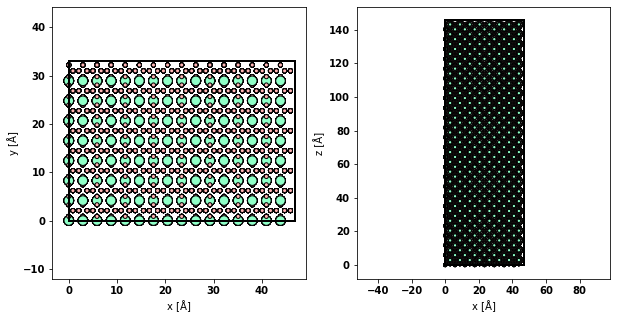

In [6]:
%matplotlib inline
SmB6 = read('sd_0527720.cif')

SmB6_110 = surface(SmB6, indices=(1, 1, 0), layers=2, periodic=True)

atoms = SmB6_110*(8,8,25)
fig,(ax1,ax2)=plt.subplots(1, 2, figsize=(10,5))
show_atoms(atoms, ax=ax1)
show_atoms(atoms, ax=ax2, plane='xz');

In [7]:
#%matplotlib Agg
#from ase.visualize import view

#view(atoms)

In [8]:
energy = 200e3

#energy_spread = 0.6
#Cc = 1.34e-3/1e-10
#focal_spread = energy_spread/energy * Cc # 1/e width of focal distribution
temporal_sigma = 0#focal_spread/np.sqrt(2) # std of focal distribution (normal distribution is proportional to e**( 1/2*(x/std)**2) )
#B_r=1e8


semiangle_cutoff = 20.52
aberrations = {
    'defocus': 0,
    'C30': 0.0e-3/1e-10,
    'C50': 0.0e-3/1e-10}

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7fc2e48d83d0>)

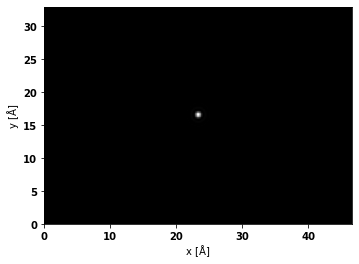

In [9]:
#probe = SMatrix(energy=energy,interpolation=1,semiangle_cutoff=semiangle_cutoff, expansion_cutoff=semiangle_cutoff*2+0.5,**aberrations, device='gpu')
probe = Probe(energy=energy, semiangle_cutoff=semiangle_cutoff,**aberrations, device='gpu')
potential = Potential(FrozenPhonons(atoms, sigmas=.06, num_configs=1), #atoms,
                      sampling=.1,
                      slice_thickness=1,
                      projection='infinite',
                      parametrization='kirkland')
probe.grid.match(potential)

#probe.build().collapse().show();
probe.show()

In [10]:
probe.ctf.nyquist_sampling*0.9

0.27499276663737354

In [11]:
scan = GridScan((potential.extent[0]*2.5/10,potential.extent[1]*2.5/10), (potential.extent[0]*7.5/10, potential.extent[1]*7.5/10), sampling = 0.2)
detector = PixelatedDetector()
detector_segmented = SegmentedDetector(0,semiangle_cutoff*1.5,1,4)

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7fc2e397c760>)

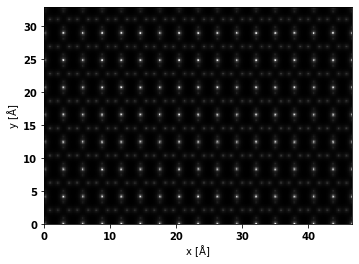

In [12]:
potential.build().project().show()

In [13]:
f=2
(potential.extent[0]*(5-f)/10,potential.extent[0]*(5-f)/10), (potential.extent[1]*(5+f)/10, potential.extent[1]*(5+f)/10)

((14.029224812911082, 14.029224812911082),
 (23.147039999999997, 23.147039999999997))

In [14]:
from abtem.detect import FlexibleAnnularDetector
measurement = probe.scan(scan, detector, potential, pbar=True,max_batch=400)

Potential:   0%|          | 0/147 [00:00<?, ?it/s]

Scan:   0%|          | 0/9711 [00:00<?, ?it/s]

In [15]:
%%time

I_reg=1e-9 
el=I_reg*1e-7/c.e # charge: 1nA times 1us 
pixel_area=1 #effectively disabled 
measurement_noisy = poisson_noise(measurement/np.mean(np.sum(measurement.array,(-2,-1))), dose=el,pixel_area=pixel_area)/el


CPU times: user 10.4 s, sys: 4.28 s, total: 14.6 s
Wall time: 14.6 s


In [16]:
#annular_detector=AnnularDetector(inner=20,outer=150)
annular_detector=AnnularDetector(inner=22,outer=50)
ress=annular_detector.integrate(measurement_noisy)

In [17]:
el

624.1509074460763

In [18]:
50e-12*1e-3/c.e

312075.45372303814

(<AxesSubplot:xlabel='alpha_x [mrad]', ylabel='alpha_y [mrad]'>,
 <matplotlib.image.AxesImage at 0x7fc2e8e71fa0>)

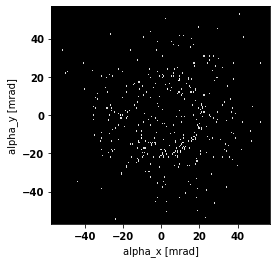

In [19]:
#%matplotlib widget
measurement_noisy[0,0].show(power=0.2)

In [20]:
measurement_noisy[0,0].shape

(214, 151)

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7fc2e4857520>)

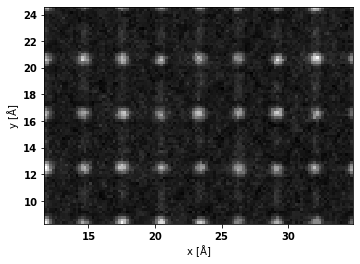

In [21]:
ress.show()

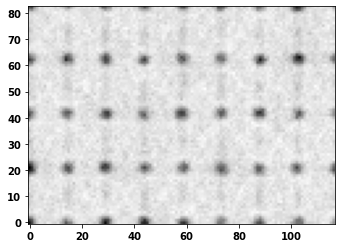

In [22]:
plt.figure()
plt.imshow(-ress.array.T,origin="lower",cmap="gray")

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7fc2e38c3490>)

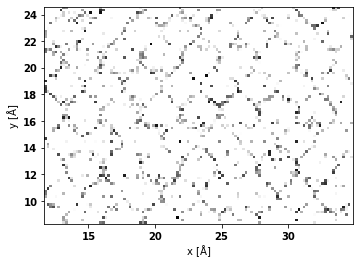

In [23]:
com = center_of_mass(measurement_noisy, return_magnitude=False)



cmap = 'gray'
com_mag=com[0].copy()
com_mag.array=np.sqrt(com[0].array**2+com[1].array**2)
com_mag.show(cmap=cmap, vmin=0, vmax=.7)

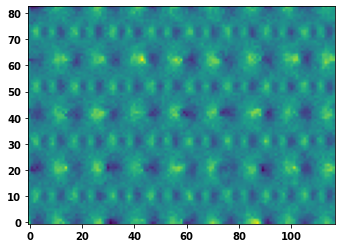

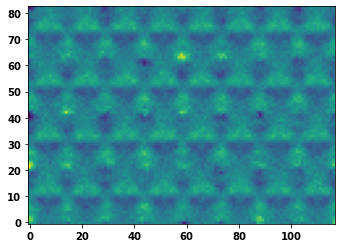

In [24]:
plt.figure()
plt.imshow(com[0].array.T,origin="lower")
plt.figure()
plt.imshow(-com[1].array.T,origin="lower")
#plt.close()

In [25]:
import py4DSTEM
# Input parameters with regularization
regLowPass = 0
regHighPass = 0*0.01
theta_recon = 0  # We get the same reconstruction with 0 rotation - try it!
flip_recon = True   # We just set this to False
paddingfactor = 2    # This parameter handles the boundary conditions via padding the reconstruction space
stepsize = 1         # Step size for each iteration
n_iter = 16           # Number of iterations

# Reconstruct the phase
phase_reg, error_ref = py4DSTEM.process.dpc.get_phase_from_CoM(
    #-I_x.array, -I_y.array, 
    -com[0].array, com[1].array, 
    theta=theta_recon, 
    flip=flip_recon,
    regLowPass=regLowPass, 
    regHighPass=regHighPass, 
    paddingfactor=paddingfactor,
    stepsize=stepsize, 
    n_iter=n_iter)

#py4DSTEM.visualize.show(phase_reg,
#                       cmap='inferno',
#                       clipvals='std',
#                       min=-2,
#                       max=5)

In [26]:
plt.figure()
plt.imshow(phase_reg.T,origin="lower",cmap="gray")

In [27]:
potential.atoms

Atoms(symbols='B19200Sm3200', pbc=True, cell=[46.76408270970361, 33.0672, 146.13775846782377], spacegroup_kinds=...)

# Ptychography

In [28]:
from abtem.custom import crop

In [29]:
def semiangle_gpts_2_extent(semiangle,gpts,energy=30e3):
    #from given semiangle (maximal semiangle detected) and gpts what is extent of calculation box in direct space
    probe_dummy=Probe(energy=energy)
    extent=1/(2*semiangle*1e-3/gpts*1/probe_dummy.wavelength)
    return(extent)

def semiangle_2_sampling_extent(semiangle,gpts,energy=30e3,direct_oversampling=4,reciprocal_oversampling=1):
    #params:
    # semiangle - semiangle which will be detected on the detector with a given number of pixels "gpts"
    # gpts
    # energy 
    #returns: (params defining direct and reciprocal sampling)
    # sampling - what should be sufficient sampling (imo at least 4x better than sampling which correspond to waves formed with the highes spatial frequency given by `semiangle`)
    # extent - corresponding extent
    probe_dummy=Probe(energy=energy)
    extent=semiangle_gpts_2_extent(semiangle,gpts,energy)*reciprocal_oversampling
    nyq_sampling = 1/(2*semiangle*1e-3*1/probe_dummy.wavelength)
    sampling = nyq_sampling/direct_oversampling # note: the scattering on eg crystal will produce diffraction discs in a dark field (in my case all those discs are in a dark field). To make the point: in my case diffraction discs lie outside of a bright field disk so nyquist frequency which correspond only to bright field edges, cannot describe the higher order scattering! (A note should be also taken with regard to antialiasing aperture which efectively reduces the maximal transmited wavelength to 2/3 of the maximal nyquist frequency which is defined by sampling in direct space)
    gpts_x=(extent/sampling).astype(int) #it is obviously reciprocal_oversampling*direct_oversampling times more than number of pixels in detectors when targeted sampling is nyq_sampling/4 
    return(sampling,extent)

# Ptychography - getting data

In [30]:
px_size = 100e-6
px_num = 192
camera_length = 12.2e-2
angular_sampling = px_size/camera_length*1e3 # in mrad
angular_extent = angular_sampling * px_num/2  # only semi angle

binning=1
reciprocal_oversampling=2
sampling,extent=semiangle_2_sampling_extent(angular_extent,px_num/binning,energy=energy,direct_oversampling=4,reciprocal_oversampling=reciprocal_oversampling)
print(sampling,extent)


0.039839577066589485 61.19359037428144


In [31]:
extent/sampling

1535.9999999999998

In [32]:
def get_potential(atoms_in,extent,sampling):
    atoms=atoms_in.copy()
    vacuum_offset=0
    atoms.center(vacuum=0) # as atoms.center() will always set vacuum to given value, it is the best to zero it first
    atoms_extent=atoms.cell.diagonal() #x,y,z
    
    
    vacuum=(extent-atoms_extent)/2 #x,y,z
    print(vacuum)
    print(atoms.cell.diagonal())
    atoms.center(vacuum=vacuum[0]+vacuum_offset,axis=(0))
    print(atoms.cell.diagonal())
    atoms.center(vacuum=vacuum[1]+vacuum_offset,axis=(1))
    print(atoms.cell.diagonal())
    
    potential_p = Potential(FrozenPhonons(atoms, sigmas=.06, num_configs=1), #atoms_p,
                      sampling=sampling,
                      #gpts=round(extent/sampling),
                      slice_thickness=2,
                      projection='infinite',
                      parametrization='kirkland')
    return potential_p,atoms

<AxesSubplot:xlabel='x [Å]', ylabel='z [Å]'>

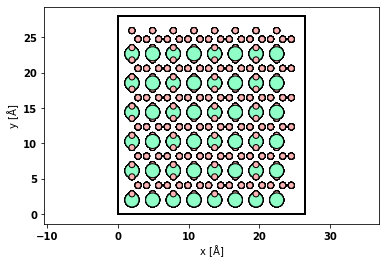

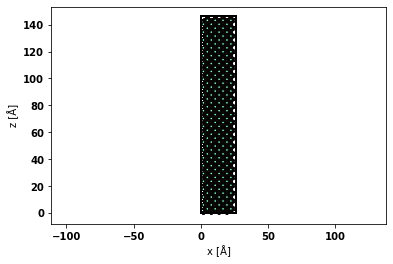

In [33]:
atoms_p=SmB6_110.copy()
atoms_p*=(4,6,25)
atoms_p.center(vacuum=2,axis=(0,1)) # setting vacuum so that extent is 200 A and that angular sampling will be good enough (phase shift due to aberrations does not alias) with defocus set to -1500 (and aperture cutoff_semiangle 12.5 mrad) also so thaxt sampling will be cca 0.2 A with 2048 gpts 
                                         # (constraining parameters are: I want as large probe as possible; I want fine details which wont be lost in poisson noise - second brag disc can be seen if dose is not too small; I work with 2048 gpts because it does not present problem current gpu.) 
atoms_p.rotate("x",0)
show_atoms(atoms_p)
show_atoms(atoms_p,plane="xz")

In [34]:
semiangle_cutoff_p=20.52
defocus_p=350

In [35]:
probe_p = Probe(energy=energy, semiangle_cutoff=semiangle_cutoff_p,defocus=defocus_p,C30=aberrations["C30"],C50=aberrations["C50"], device='gpu')
#potential_p = Potential(FrozenPhonons(atoms_p, sigmas=.06, num_configs=1), #atoms_p,
#                      sampling=.1,
#                      gpts=1024,
#                      slice_thickness=0.25,
#                      projection='infinite',
#                      parametrization='kirkland')

if extent < np.max(atoms_p.cell.diagonal()[:2]):
    raise ValueError("sample is larger than calculation box")
potential_p,atoms_=get_potential(atoms_p,extent,sampling)

probe_p.grid.match(potential_p)

print(potential_p.sampling)

probe_p.build().show();

[ 19.33395814  18.62440209 -42.04390041]
[ 22.52567409  23.9447862  145.2813912 ]
[ 61.19359037  23.9447862  145.2813912 ]
[ 61.19359037  61.19359037 145.2813912 ]
(0.039839577066589485, 0.03983957706658948)


In [36]:
#np.shape(potential_p.build().array)

In [37]:
detector_p = PixelatedDetector(None)

I=50e-12
spatial_sigma = 0#get_gaussian_spread(probe_p.ctf.semiangle_cutoff,probe_p.energy,B_r,I)

In [38]:
incoh_probe=incoherent_probe(probe_p,temporal_sigma=temporal_sigma,spatial_sigma=spatial_sigma)
r95, _, _, _= get_probe_radius(probe_measurement=incoh_probe,current_ratio=0.95)
d95=2*r95

In [39]:
atoms_.positions[0]

array([24.32310122, 20.69110209,  2.0663879 ])

In [40]:
scan_gpts = 10
scan_sampling = d95*0.15
scan_start = np.min(atoms_.positions,axis=0)[:2]
scan_end = scan_start + np.array( (scan_sampling*scan_gpts,) * 2)
scan_p = GridScan(scan_start, scan_end, sampling = scan_sampling)# sampling should be lower then 0.7 of probe width
positions_grid = scan_p.get_positions()
positions = positions_grid + np.random.uniform(-scan_sampling/10,scan_sampling/10,size=positions_grid.shape)
print("scan_sampling: ",scan_sampling)

scan_sampling:  2.241694265527348


In [41]:
plt.figure()
plt.plot(positions_grid[:,0],positions_grid[:,1],"x")
plt.plot(positions[:,0],positions[:,1],".")

In [42]:
positions.shape

(100, 2)

In [43]:
len(positions)

100

In [44]:
%%time 
measurement_mc=incoherent_scan_mc(probe_p,positions,detector_p,potential_p,temporal_sigma=temporal_sigma,spatial_sigma=spatial_sigma,max_batch_scan=100)

Multislice:   0%|          | 0/73 [00:00<?, ?it/s]

CPU times: user 4min 23s, sys: 9.1 s, total: 4min 32s
Wall time: 16.7 s


In [45]:
potential_p.build().project().show()

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7fc2e31cff70>)

(<AxesSubplot:xlabel='alpha_x [mrad]', ylabel='alpha_y [mrad]'>,
 <matplotlib.image.AxesImage at 0x7fc2e31e91f0>)

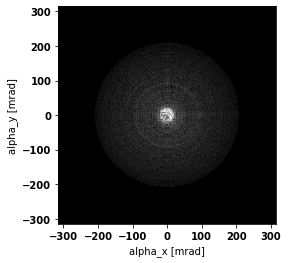

In [46]:
measurement_mc[0].show(power=0.2)

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7fc2e406f7c0>)

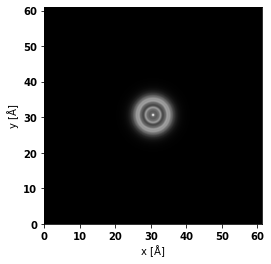

In [47]:
probe_p.show()

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7fc2e31a00d0>)

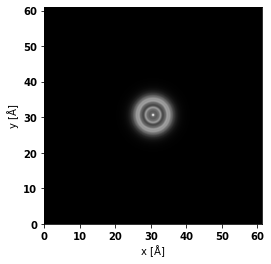

In [48]:
#%matplotlib widget
incoh_probe=incoherent_probe(probe_p,temporal_sigma,spatial_sigma)
incoh_probe.show()

In [49]:
measurement_p_raw = measurement_mc
#measurement_p_crop = incoherent_scan(probe_p,scan_p,detector_p,potential_p,temporal_sigma=temporal_sigma*0,spatial_sigma=spatial_sigma*0,max_batch=400)

(<AxesSubplot:xlabel='alpha_x [mrad]', ylabel='alpha_y [mrad]'>,
 <matplotlib.image.AxesImage at 0x7fc2e3b496d0>)

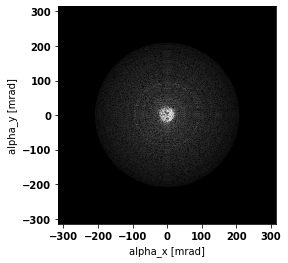

In [50]:
measurement_p_raw[5].show(power=0.2)

In [51]:
np.sum(measurement_p_raw[0].array)

0.9957515

In [52]:
np.shape(measurement_p_raw)

(100, 1536, 1536)

In [53]:
#measurement_p_crop=crop(measurement_p_raw,extent=(171.5,166)) # setting angular extent to 84 so that cca 256 pixels are in detector. Potential extent should be sufficiently set so that sampling will be not to fine and not to rough so that maximal scattering angle will be as wanted (second brag disk). 
measurement_p_crop=crop(measurement_p_raw,extent=(angular_extent*2,angular_extent*2))
#measurement_p_crop=crop(measurement_p_raw,extent=(170,160.8))

(629.5081792614134, 629.5081792614134)
(384, 384)
(576, 576)
(100, 384, 384)
(3,)


In [54]:
measurement_p_crop.calibrations[1].sampling

0.4098360542066493

(<AxesSubplot:xlabel='alpha_x [mrad]', ylabel='alpha_y [mrad]'>,
 <matplotlib.image.AxesImage at 0x7fc2e4063970>)

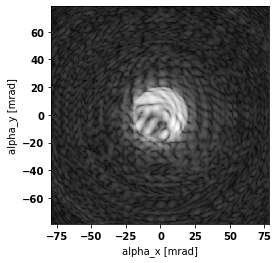

In [55]:
#%matplotlib inline
measurement_p_crop[0].show(power=0.2)

# Adding noise

In [56]:
el=I*100e-6/c.e# number of electrons in diffraction pattern
pixel_area=1 #effectively disabled 
print(el)

31207.54537230382


In [57]:
measurement_noisy = poisson_noise(measurement_p_crop/np.mean(np.sum(measurement_p_raw.array,(-2,-1))), dose=el,pixel_area=pixel_area)/el

In [58]:
#measurement_noisy=bandlimit(measurement_noisy,12.5)

6728.786471449089


(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7fc2e3e20f40>)

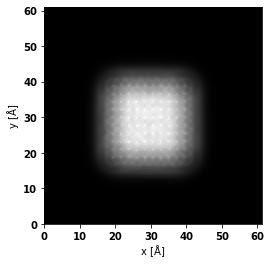

In [59]:
max_dose,dose_map=get_radiation_dose(incoh_probe,positions,el)
print(max_dose) # total number of electrons per pixel area times fraction of total iradiance in pixel 
dose_map.show()

61514.09526895309


(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7fc2e3419670>)

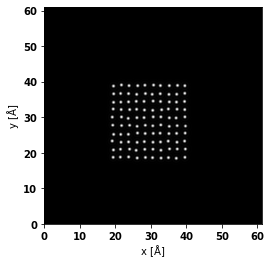

In [60]:
probe_p_dummy = probe_p.copy()
probe_p_dummy.ctf.defocus = 0
incoh_probe_dummy = incoherent_probe(probe_p_dummy,temporal_sigma,spatial_sigma)
max_dose_dummy,dose_map_dummy=get_radiation_dose(incoh_probe_dummy,positions,el)
print(max_dose_dummy) # total number of electrons per pixel area times fraction of total iradiance in pixel 
dose_map_dummy.show()

# Downsampling diffraction pattern

In [61]:
if 1:
    #Downsample diffraction patter by factor of `p_num`
    p_num=reciprocal_oversampling # downsampling is turned off when p_num = 1
    shape_orig=np.shape(measurement_noisy)
    array=np.zeros([shape_orig[0],shape_orig[1]//p_num,shape_orig[2]//p_num])

    for i in range(np.shape(measurement_noisy)[0]):
        m = measurement_noisy.array[i]
        if p_num==1:
            array[i]=m
        else:
            #array[i,j]=m[0::p_num,0::p_num]+m[0::p_num,1::p_num]+m[1::p_num,0::p_num]+m[1::p_num,1::p_num]            
            for k in range(p_num):
                for l in range(p_num):
                    array[i]+=m[k::p_num,l::p_num]

    #setting calibrations and creating measurement
    cals=(None,)+tuple(i.copy() for i in measurement_noisy.calibrations[1:]) # cannot use equals because it wouldnt copy but it would instead pass refference
    print("sampling in reciprocal space before:")
    print(cals[1].sampling,cals[2].sampling)
    cals[1].sampling*=p_num
    cals[2].sampling*=p_num
    print("sampling in reciprocal space after:")
    print(cals[1].sampling,cals[2].sampling)
    measurement_resampled= Measurement(array, calibrations=cals, name=measurement_noisy.name, units=measurement_noisy.units) 

sampling in reciprocal space before:
0.4098360542066493 0.4098360542066493
sampling in reciprocal space after:
0.8196721084132986 0.8196721084132986


In [62]:
#measurement_resampled.show(power=0.2)

# Reconstruction

In [63]:
#measurement_p=measurement_noisy
measurement_p=measurement_resampled

In [64]:
measurement_p[0].array.shape

(192, 192)

(<AxesSubplot:xlabel='alpha_x [mrad]', ylabel='alpha_y [mrad]'>,
 <matplotlib.image.AxesImage at 0x7fc2e5680250>)

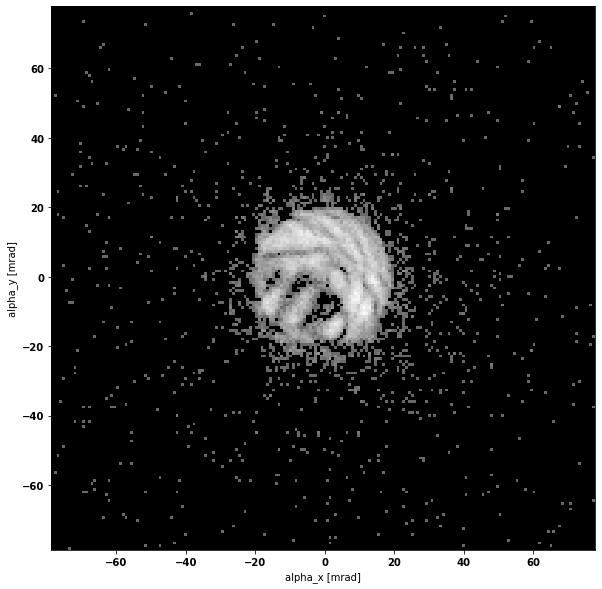

In [65]:
measurement_p[0].show(power=0.2,figsize=(10,10))

In [66]:
measurement_p.array.shape

(100, 192, 192)

In [67]:
positions_min=np.min(positions,0)
positions_max=np.max(positions,0)
position_center=(positions_max+positions_min)/2
positions_centered = positions - position_center + np.array(probe_p.extent)/reciprocal_oversampling/2 

In [68]:
probe_guess = Probe(semiangle_cutoff=semiangle_cutoff_p, energy=energy,defocus=defocus_p, C30=aberrations["C30"],C50=aberrations["C50"])#, C12=0, extent=150, gpts=128)
modes = 1
slices = 6
thickness = 150
reconstructions=invms(bandlimit(measurement_p,500),probe_guess,max_angle=None,positions=positions_centered,alpha=1,fac=1,beta=1,maxiter=64,k_modes=1,slices=slices,slice_thickness=thickness/slices,modes=modes,device="gpu",return_iterations=True)

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

probes norm:  [0.89043508] probes norm sum:  0.8904350773371812
SSE:  9.867260019617002e-09
probes norm:  [0.90348236] probes norm sum:  0.9034823604941465
SSE:  5.132535060773007e-09
probes norm:  [0.92036691] probes norm sum:  0.9203669080046202
SSE:  4.049298429370569e-09
probes norm:  [0.9226441] probes norm sum:  0.9226440960813111
SSE:  3.4856778814882137e-09
probes norm:  [0.92936673] probes norm sum:  0.9293667292703216
SSE:  3.1655111063382012e-09
probes norm:  [0.93579502] probes norm sum:  0.9357950181791961
SSE:  2.9343832999732173e-09
probes norm:  [0.94434988] probes norm sum:  0.944349877484522
SSE:  2.7446233883449216e-09
probes norm:  [0.94379282] probes norm sum:  0.9437928249004618
SSE:  2.5895001165281893e-09
probes norm:  [0.94702544] probes norm sum:  0.9470254394536537
SSE:  2.4785169549144828e-09
probes norm:  [0.95262761] probes norm sum:  0.952627607665997
SSE:  2.371922207485345e-09
probes norm:  [0.9533286] probes norm sum:  0.9533285964891332
SSE:  2.270336

In [69]:
%matplotlib inline
plot_every =32

#fig, axes = plt.subplots(2, int(np.ceil(len(reconstructions[0]) / plot_every)), figsize=(20,20))

#for i, j in enumerate(range(0, len(reconstructions[0]), plot_every)):
#    axes[0,i].imshow(np.angle(reconstructions[0][j][0].array).T, origin='lower', cmap='gray')
#    axes[1,i].imshow(np.abs(reconstructions[1][j][0].array).T ** 2, origin='lower', cmap='gray')
#    for ax in (axes[0,i], axes[1,i]):
#        ax.axis('off')
      
fig, axes = plt.subplots(1+modes, int(np.ceil(len(reconstructions[0]) / plot_every)), figsize=(20,20))

for i, j in enumerate(range(0, len(reconstructions[0]), plot_every)):
    axes[0,i].imshow(np.angle(reconstructions[0][j][-1].array).T, origin='lower', cmap='gray')
    for mode in range(modes): 
        axes[1+mode,i].imshow(np.abs(reconstructions[1][j][mode].array).T ** 2, origin='lower', cmap='gray')
    for ax in (axes[0,i],)+tuple([axes[1+mode,i] for mode in range(modes)]):
        ax.axis('off')        
    
plt.tight_layout()

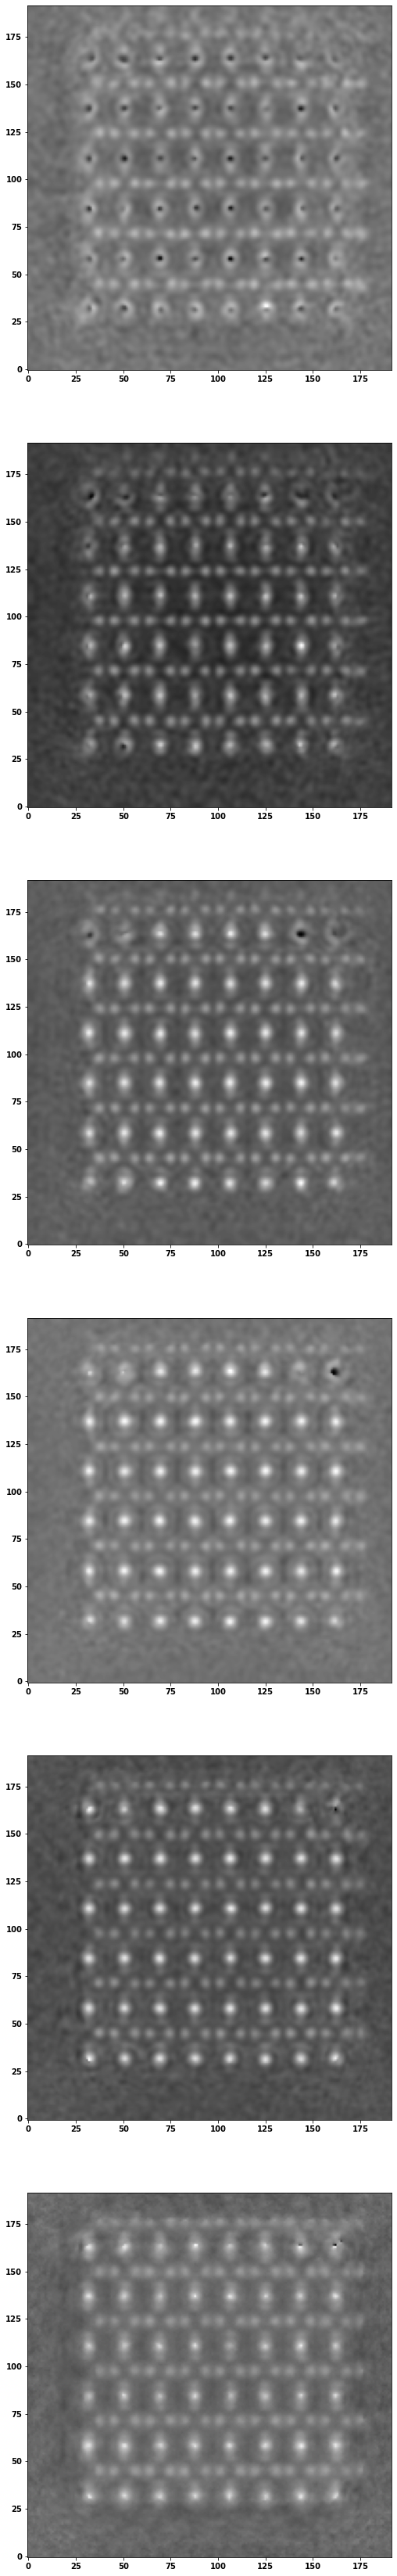

In [70]:
%matplotlib inline
plt.figure(figsize=(10,10*slices))
for i in range(slices):
    plt.subplot(slices,1,i+1)
    plt.imshow(np.angle(reconstructions[0][-1][i].array).T, origin='lower', cmap='gray')
#plt.xlim(50,150)
#plt.ylim(50,150)
#plt.clim(-0.5,1)

In [71]:
#%matplotlib widget
plt.figure()
plt.imshow(np.abs(probe_guess.build().array.get())**2)

# Reconstructing without modes and slices

In [72]:
probe_guess = Probe(semiangle_cutoff=semiangle_cutoff_p, energy=energy,defocus=defocus_p,C30=aberrations["C30"],C50=aberrations["C50"])#, C12=800)#, extent=150, gpts=128)
positions = scan_p.get_positions()
reconstructions=invms(bandlimit(measurement_p,500),probe_guess,max_angle=None,positions=positions_centered,alpha=1,fac=0.2,beta=1,maxiter=64,modes=1,device="gpu",return_iterations=True)

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

probes norm:  [8.51876179] probes norm sum:  8.518761789610927
SSE:  1.2163800828060233e-08
probes norm:  [44.6701177] probes norm sum:  44.67011769583584
SSE:  9.558862848424591e-09
probes norm:  [195.2827117] probes norm sum:  195.28271170120857
SSE:  9.02236722677277e-09
probes norm:  [767.29372348] probes norm sum:  767.2937234830163
SSE:  8.771664706606925e-09
probes norm:  [2640.26752394] probes norm sum:  2640.2675239416376
SSE:  8.426369917370999e-09
probes norm:  [8500.35518437] probes norm sum:  8500.355184373577
SSE:  8.130127474543095e-09
probes norm:  [25923.67572203] probes norm sum:  25923.675722026306
SSE:  8.110059786305425e-09
probes norm:  [72672.487129] probes norm sum:  72672.4871289954
SSE:  7.929356785863678e-09
probes norm:  [201889.18778244] probes norm sum:  201889.18778244493
SSE:  7.835554851795815e-09
probes norm:  [596495.91063203] probes norm sum:  596495.9106320346
SSE:  7.865431961059179e-09
probes norm:  [1814248.31935472] probes norm sum:  1814248.319

In [73]:
#%matplotlib inline
plot_every = 16

fig, axes = plt.subplots(2, int(np.ceil(len(reconstructions[0]) / plot_every)), figsize=(20,20))
for i, j in enumerate(range(0, len(reconstructions[0]), plot_every)):
    axes[0,i].imshow(np.angle(reconstructions[0][j][0].array).T, origin='lower', cmap='gray')
    axes[1,i].imshow(np.abs(reconstructions[1][j][0].array).T ** 2, origin='lower', cmap='gray')
    for ax in (axes[0,i], axes[1,i]):
        ax.axis('off')
    
plt.tight_layout()

In [74]:
#%matplotlib widget
plt.figure()
plt.imshow(np.angle(reconstructions[0][-1][0].array).T, origin='lower', cmap='gray')